In [327]:
import pandas as pd
import json
import numpy as np
from globals import BASE_DIR
import os
import matplotlib.pyplot as plt
import math
import random
from postprocess_baseline_top_k import dataset_metadata
from evaluation_metrics import ndcg, calculate_arp_poplift, jensen_shannon, evaluation_user_group_means

top_k_eval = 10

general_models = ["BPR", "SimpleX"]
context_models = ["LORE", "USG"]

available_datasets = ["brightkite", "foursquaretky", "gowalla", "snoward", "yelp"]

dataset = "brightkite"

#valid_popularity = "business_popularity:float"
valid_popularity = "item_pop"
recommendation_dirpart = "recommendations"

In [328]:
def process_top_k_json(input_file, output_file, k=10):
    """
    Process top-k recommendations from a JSON file, keeping only the item IDs for each user.

    Args:
    - input_file (str): Path to the original JSON file.
    - output_file (str): Path to save the processed JSON file.
    - k (int): Number of top-k recommendations to keep per user.
    """
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    try:
        with open(input_file, 'r') as infile:
            data = json.load(infile)

        top_k_result = {}
        for user_id, recommendations in data.items():
            if recommendations and isinstance(recommendations[0], dict):
                item_ids = recommendations[0]["item_id"][:k]
                top_k_result[user_id] = item_ids

        with open(output_file, 'w') as outfile:
            json.dump(top_k_result, outfile, indent=4)
        print(f"Processed file saved to: {output_file}")
    
    except Exception as e:
        print(f"Error processing {input_file}: {e}")

In [329]:
def create_model_directories(dataset, data, base_dir, recommendation_dirpart):
    model_directories = {}
    methods = ["baseline", "cp", "cp_min_js", "upd"]

    def recommender_dir_combiner(dataset, modelpart, method):
        return f"{base_dir}{dataset}_dataset/{recommendation_dirpart}/{modelpart}/{method + '/'}top_k_recommendations.json"

    for result in data:
        model_name = result["model"]
        model_directories[model_name] = {}
        
        for method in methods:
            model_directories[model_name][method] = recommender_dir_combiner(dataset, result["directory"], method)
    
    return model_directories

def sample_user_groups(user_groups, sample_size=100):
    sampled_groups = {}
    for group, ids in user_groups.items():
        if len(ids) >= sample_size:
            sampled_groups[group] = random.sample(ids, sample_size)
        else:
            print(f"Warning: Group '{group}' has less than {sample_size} users. Sampling all users.")
            sampled_groups[group] = ids
    return sampled_groups


def open_ground_truth_user_group(dataset, valid_popularity=valid_popularity):

    # Stays the same across all models 
    train_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.train.inter", sep="\t")
    test_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.test.inter", sep="\t")
    valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t")
    #valid_data = pd.read_csv(f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.valid.inter", sep="\t") # originale struktur !!!
    train_data = pd.concat([train_data, valid_data])
    user_group_dir = f"{BASE_DIR}{dataset}_dataset/{dataset}_user_id_popularity.json"
    with open(user_group_dir) as f:
        user_groups = json.load(f)

    checkin_df = pd.read_csv(
        f"{BASE_DIR}{dataset}_dataset/processed_data_recbole/{dataset}_sample.inter",
        sep="\t",
    )
    # Calculate item popularity
    value_counts = checkin_df["item_id:token"].value_counts().reset_index()
    value_counts.columns = ["item_id:token", "count"]
    value_counts[valid_popularity] = value_counts["count"] / len(value_counts)
    checkin_df = checkin_df.merge(
        value_counts[["item_id:token", valid_popularity]],
        on="item_id:token",
        how="left",
    )
    checkin_df.sort_values(by=valid_popularity, ascending=False, inplace=True)
    item_popularity = checkin_df.drop_duplicates(subset="item_id:token", keep="first")[
        ["item_id:token", valid_popularity]
    ]

    h_group = item_popularity.head(int(len(item_popularity) * 0.2))
    h_group["item_pop_group"] = "h"
    t_group = item_popularity.tail(int(len(item_popularity) * 0.2))
    t_group["item_pop_group"] = "t"
    m_group = item_popularity[
        ~item_popularity["item_id:token"].isin(h_group["item_id:token"]) &
        ~item_popularity["item_id:token"].isin(t_group["item_id:token"])
    ]
    m_group["item_pop_group"] = "m"

    item_popularity = pd.concat([h_group, m_group, t_group])
    item_popularity.sort_values(by=valid_popularity, inplace=True, ascending=False)




    upts = checkin_df.groupby("user_id:token")[valid_popularity].mean().reset_index()
    upts.columns = ["user_id:token", "upts"]
    return train_data, test_data, user_groups, item_popularity, upts


In [330]:
data = dataset_metadata(dataset, recommendation_dirpart)

In [331]:
model_dirs = create_model_directories(dataset, data, BASE_DIR, recommendation_dirpart)

In [332]:
model_dirs

{'BPR': {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Oct-26-2024_15-21-48/baseline/top_k_recommendations.json',
  'cp': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Oct-26-2024_15-21-48/cp/top_k_recommendations.json',
  'cp_min_js': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Oct-26-2024_15-21-48/cp_min_js/top_k_recommendations.json',
  'upd': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-BPR-Oct-26-2024_15-21-48/upd/top_k_recommendations.json'},
 'LORE': {'baseline': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-contextpoi-LORE-Sep-16-2024_09-00-00/baseline/top_k_recommendations.json',
  'cp': '/Volumes/Forster Neu/Masterarbeit Data/brightkite_dataset/recommendations/brightkite_sample-contextpoi-LORE-Sep-16-2024_09-00-00/cp/t

In [333]:
def unstack_recommendations(df):
    # Repeat each user_id for the length of their item_id:token list
    unstacked_df = df.explode(["item_id:token"]).reset_index(drop=True)
    return unstacked_df

In [334]:
def top_k_to_df(recommender_dir, top_k_eval=top_k_eval):
    # Load the JSON data
    with open(recommender_dir) as f:
        data = json.load(f)

    # Initialize a list to store the recommendations
    base_recommendations = []

    # Iterate through the data and structure it for DataFrame
    for user, items in data.items():
        for item in items:
            base_recommendations.append({
                "user_id:token": user,
                "item_id:token": item
            })

    # Create a DataFrame from the structured recommendations
    base_df = pd.DataFrame(base_recommendations)

    # Assuming `unstack_recommendations` is a function you want to apply here:
    base_df = unstack_recommendations(base_df)

    df = base_df.groupby('user_id:token').head(top_k_eval)

    return df


In [335]:
train_data, test_data, user_groups, item_popularity, upts = open_ground_truth_user_group(dataset)
user_groups['all'] = user_groups['high'] + user_groups['medium'] + user_groups['low']

/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_19651/2597525684.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  h_group["item_pop_group"] = "h"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_19651/2597525684.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t_group["item_pop_group"] = "t"
/var/folders/9q/p0b6nwnd5071040x3849mdvc0000gn/T/ipykernel_19651/2597525684.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

In [340]:
def create_pop_distributions(data):
    data = data.merge(item_popularity, on="item_id:token", how="left")
    g1 = data.loc[data["user_id:token"].isin(user_groups["high"])].value_counts("item_pop_group", normalize=True).rename("g1")
    g2 = data.loc[data["user_id:token"].isin(user_groups["medium"])].value_counts("item_pop_group", normalize=True).rename("g2")
    g3 = data.loc[data["user_id:token"].isin(user_groups["low"])].value_counts("item_pop_group", normalize=True).rename("g3")
    all = data.value_counts("item_pop_group", normalize=True).rename("all")
    distr_df = pd.DataFrame([g1, g2, g3, all]).fillna(0)
    return distr_df


ground_truth_distr = create_pop_distributions(train_data)

In [341]:
ground_truth_distr

item_pop_group,h,m,t
g1,0.440197,0.438012,0.121791
g2,0.363624,0.513455,0.122921
g3,0.273924,0.567058,0.159018
all,0.354324,0.514497,0.131179


Plots saved to 'item_popularity_distribution.png'


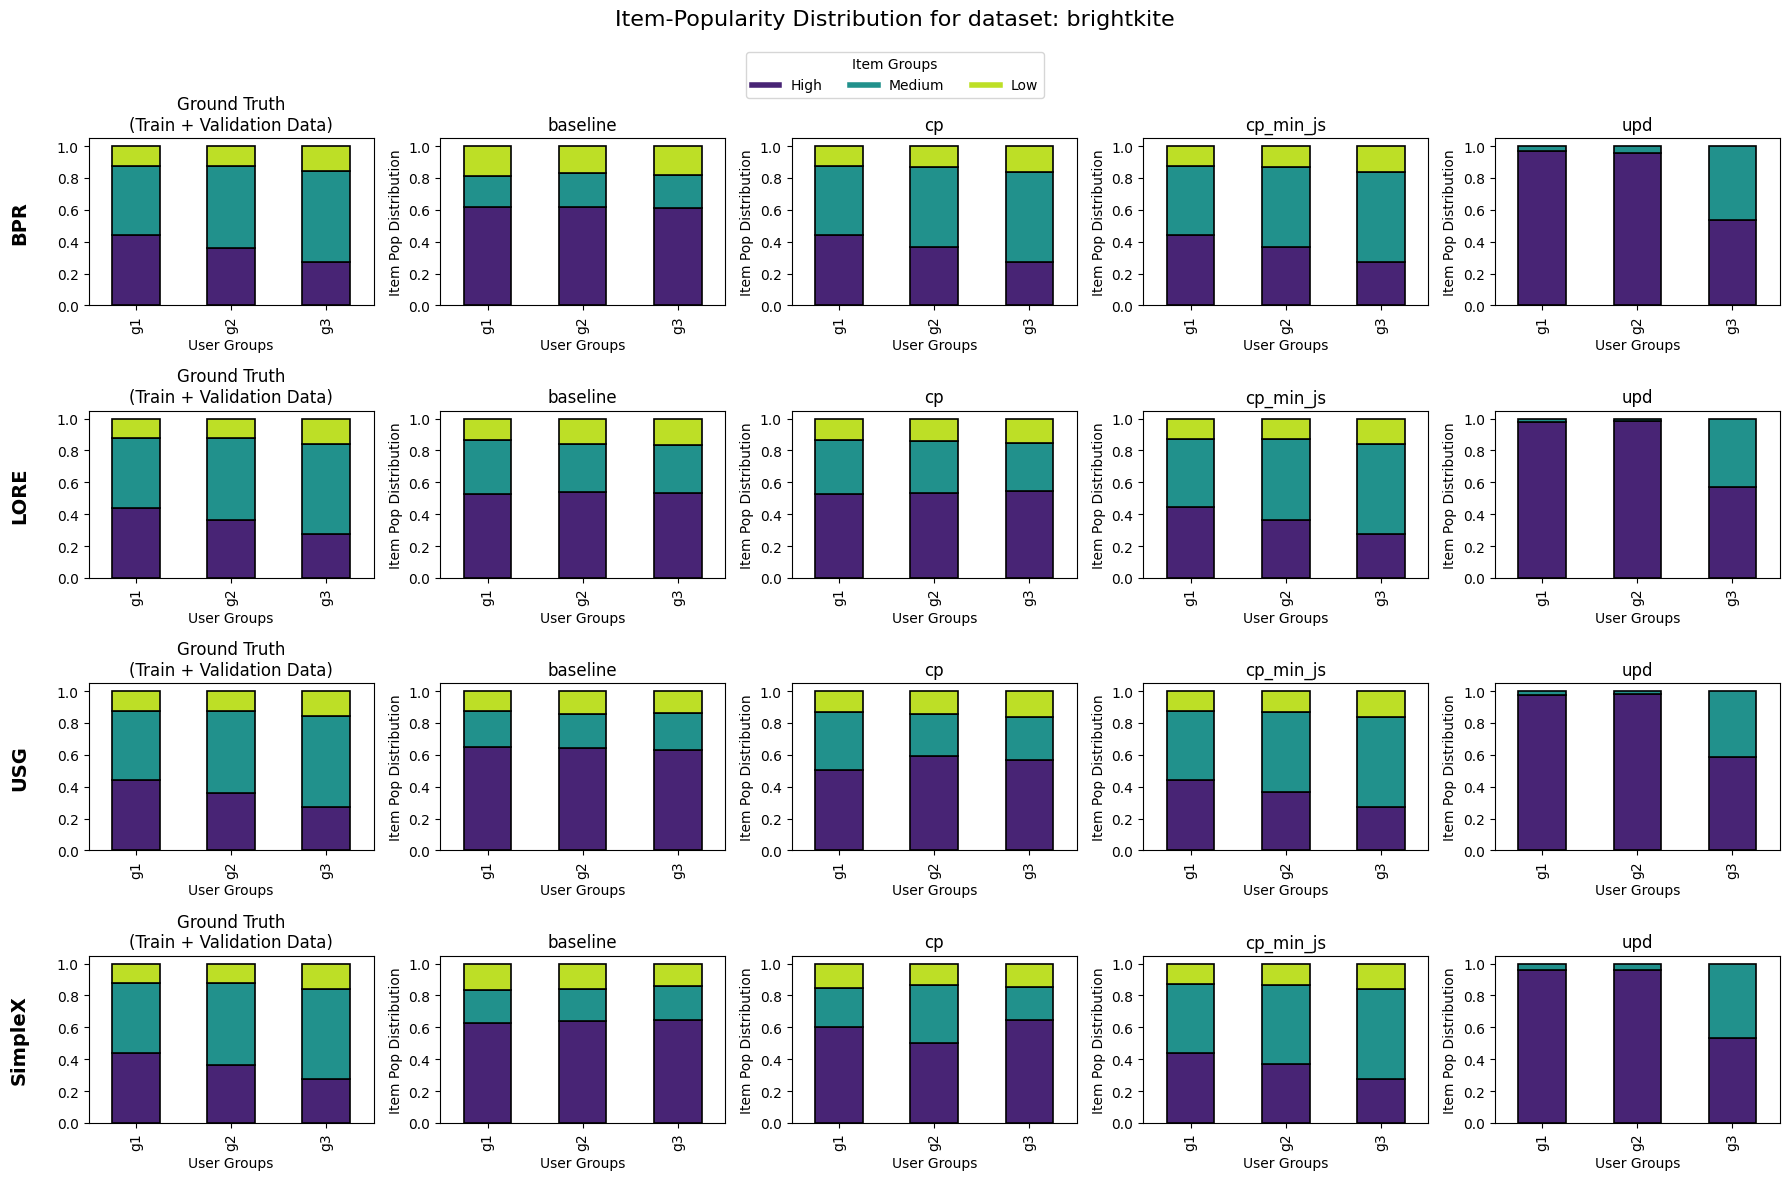

In [324]:
# Function for plotting popularity distribution (no legend inside this function)
def plot_popularity_distribution(ax, distr_df, label):
    colors = plt.cm.viridis([0.1, 0.5, 0.9])
    bars = distr_df.plot(kind='bar', stacked=True, ax=ax, color=colors, legend=False, edgecolor='black', linewidth=1.2)
    ax.set_title(f"{label}")
    ax.set_xlabel("User Groups")
    ax.set_ylabel("Item Pop Distribution")
    return distr_df


results = {}
# Create a plot for each model and method
fig, axs = plt.subplots(len(model_dirs), 5, figsize=(18, 12))  # Adjusted for the number of models

# Loop through models and methods to compute results and plot
for i, (model_name, methods) in enumerate(model_dirs.items()):
    results[model_name] = {}

    # Plot the ground truth in the first column of each row
    ax = axs[i, 0]
    plot_popularity_distribution(ax, train_data, item_popularity, user_groups, "Ground Truth\n(Train + Validation Data)")

    for j, (method_name, json_file) in enumerate(methods.items()):
        # Load recommendation data for the current model and method
        with open(json_file, 'r') as f:
            eval_data = json.load(f)

        # Convert the JSON to DataFrame
        df = top_k_to_df(json_file)

        # Compute evaluation scores
        ndcg_scores = ndcg(df, test_data, top_k_eval)
        df_with_item_pop = df.merge(item_popularity, on="item_id:token", how="left")
        arp_scores, poplift_scores = calculate_arp_poplift(df_with_item_pop, item_popularity, upts, valid_popularity)
        
        # Evaluate user groups
        group_eval = evaluation_user_group_means(ndcg_scores, arp_scores, poplift_scores, user_groups)
        
        # Store the results in a dictionary
        results[model_name][method_name] = group_eval

        # Plot the popularity distribution for the current method in the next columns
        ax = axs[i, j + 1]  # Select the appropriate subplot (shifted by 1 column for method)
        plot_popularity_distribution(ax, df, item_popularity, user_groups, method_name)

    # Add the model name (e.g., "BPR") above the row of plots
    axs[i, 0].set_ylabel(model_name, fontsize=14, weight='bold', labelpad=20)

# Set the main title and adjust layout
fig.suptitle(f"Item-Popularity Distribution for dataset: {dataset}", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add the legend once after the loop
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in plt.cm.viridis([0.1, 0.5, 0.9])]
labels = ["High", "Medium", "Low"]
fig.legend(handles, labels, title="Item Groups", loc='upper center', bbox_to_anchor=(0.5, 0.95), ncol=3)

# Save the plot to a file
plt.savefig(f"{BASE_DIR}{dataset}_dataset/plots/item_popularity_distribution.png")
# Print confirmation
print("Plots saved to 'item_popularity_distribution.png'")


In [325]:
# Collect results into rows for CSV output
rows = []
for model_name, methods in results.items():
    for method_name, group_eval in methods.items():
        for group_name, metrics in group_eval.items():
            row = {
                'dataset': dataset,
                'model': model_name,
                'method': method_name,
                'user_group': group_name,
                'ndcg': metrics['ndcg_mean'],
                'arp': metrics['arp_mean'],
                'poplift': metrics['poplift_mean']
            }
            rows.append(row)

# Create a DataFrame from the rows
df_results = pd.DataFrame(rows)

# Save the evaluation results to a CSV file
df_results.to_csv(f'{BASE_DIR}/{dataset}_dataset/evaluation_results.csv', index=False)
print("Evaluation results have been saved to 'evaluation_results.csv'")

Evaluation results have been saved to 'evaluation_results.csv'
